## Feature Engineering

- Time decomposition
- RPM * Torque
- rpm missing
- Air temperature second peak


In [13]:
import pandas as pd
import numpy as np
import seaborn as sns

df = pd.read_csv('modelling_dataset.csv')
df.columns

Index(['UID', 'Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target',
       'Failure Type', 'Timestamp', 'later_date', 'Error',
       'Heat Dissipation Failure', 'No Failure', 'Overstrain Failure',
       'Power Failure', 'Random Failures', 'Tool Wear Failure', 'rpm_null'],
      dtype='object')

In [14]:
df['rpm_x_torque'] = df['Rotational speed [rpm]'] * df['Torque [Nm]']
bins = pd.IntervalIndex.from_tuples([(3.7, 80), (81, 160), (161, 214.5)])
d = dict(zip(bins, [41.85, 120.5, 187.7]))
df['discrete_torque'] = pd.cut(df['Torque [Nm]'], bins=bins).map(d)
bins = pd.IntervalIndex.from_tuples([(265.6, 275), (276, 290), (291, 304.6)])
d = dict(zip(bins, ["270.4", "283.0", "297.75"]))
df['discrete_air_temp'] = pd.cut(df['Air temperature [K]'], bins=bins).map(d)
df['air_temp_process_temp'] = df['Process temperature [K]'] / df['Air temperature [K]']

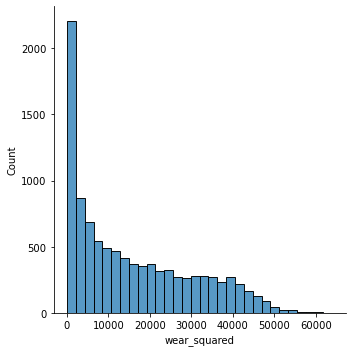

In [15]:
df['wear_squared'] = df['Tool wear [min]']**2
sns.displot(df['wear_squared'])

In [16]:
# day, dayofweek, month, year, hour, minute
df['year'] = pd.to_datetime(df['Timestamp']).dt.year
df['month'] = pd.to_datetime(df['Timestamp']).dt.month
df['day'] = pd.to_datetime(df['Timestamp']).dt.day
df['dayofweek'] = pd.to_datetime(df['Timestamp']).dt.dayofweek
df['hour'] = pd.to_datetime(df['Timestamp']).dt.hour
df = df.drop(columns=['Timestamp'])

In [17]:
feature_cols = df.columns
failure_one_hot_cols = ['Error', 'Heat Dissipation Failure', 'No Failure',
'Tool Wear Failure', 'Overstrain Failure', 'Power Failure', 'Random Failures']
feature_cols = feature_cols.drop(['UID', 'Failure Type'] + failure_one_hot_cols)
df[feature_cols]

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,later_date,rpm_null,rpm_x_torque,discrete_torque,discrete_air_temp,air_temp_process_temp,wear_squared,year,month,day,dayofweek,hour
0,298.1,308.6,1551.0,42.8,0,0,False,False,66382.8,41.85,297.75,1.035223,0,2001,12,1,5,0
1,298.2,308.7,1408.0,46.3,3,0,False,False,65190.4,41.85,297.75,1.035211,9,2001,12,1,5,1
2,298.1,308.5,1498.0,49.4,5,0,False,False,74001.2,41.85,297.75,1.034888,25,2001,12,1,5,2
3,298.2,308.6,1433.0,39.5,7,0,False,False,56603.5,41.85,297.75,1.034876,49,2001,12,1,5,3
4,298.2,308.7,1408.0,40.0,9,0,False,False,56320.0,41.85,297.75,1.035211,81,2001,12,1,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,298.8,308.4,1604.0,29.5,14,0,False,False,47318.0,41.85,297.75,1.032129,196,2003,1,21,1,11
9995,298.9,308.4,1632.0,31.8,17,0,False,False,51897.6,41.85,297.75,1.031783,289,2003,1,21,1,12
9996,299.0,308.6,1645.0,33.4,22,0,False,False,54943.0,41.85,297.75,1.032107,484,2003,1,21,1,13
9997,299.0,308.7,1408.0,48.5,25,0,False,False,68288.0,41.85,297.75,1.032441,625,2003,1,21,1,14


In [18]:
#from sklearn.experimental import enable_iterative_imputer
#from sklearn.impute import IterativeImputer
#from sklearn.ensemble import RandomForestRegressor
#
#imp = IterativeImputer(estimator=RandomForestRegressor())
#imp.fit(df[feature_cols])
#df_imp = imp.transform(df[feature_cols])
#df_imp = pd.DataFrame(df_imp, columns=feature_cols)
#df_imp.to_csv('imp_df.csv', index=False)

df_imp = pd.read_csv('imp_df.csv')

In [19]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def eval(model, X_test, y_test, X_train, y_train, y, roc_curve=False):
    test = model.predict(X_test)
    print(y.value_counts()/4)
    print(y_test.value_counts())
    print(classification_report(y_test, test))
    cm = confusion_matrix(y_test, test)
    fig, ax= plt.subplots(figsize=(15, 15))
    sns.heatmap(cm, annot=True, ax=ax)
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(model.classes_); ax.yaxis.set_ticklabels(model.classes_);
    plt.show()
    sns.barplot(x=model.feature_importances_, y=X_train.columns)
    if roc_curve:
        y_score = model.predict_proba(X_test)
        print(y_score)
        plt.show()
        label_binarizer = LabelBinarizer().fit(y_train)
        y_onehot_test = label_binarizer.transform(y_test)
        for l in y.unique():
            class_id = np.flatnonzero(label_binarizer.classes_ == l)[0]
            RocCurveDisplay.from_predictions(y_onehot_test[:, class_id], y_score[:, class_id])
            print(y_onehot_test[:, class_id])
            print(y_score[:, class_id])
            plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
            plt.axis("square")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(f"{l}")
            plt.legend()
            plt.show()
        return test, y_score

No Failure                  2388.00
Heat Dissipation Failure      28.00
Error                         25.00
Power Failure                 23.75
Overstrain Failure            19.50
Tool Wear Failure             11.25
Random Failures                4.25
Name: Failure Type, dtype: float64
No Failure                  1911
Heat Dissipation Failure      22
Error                         20
Power Failure                 19
Overstrain Failure            16
Tool Wear Failure              9
Random Failures                3
Name: Failure Type, dtype: int64
                          precision    recall  f1-score   support

                   Error       0.00      0.00      0.00        20
Heat Dissipation Failure       0.95      0.91      0.93        22
              No Failure       0.99      1.00      0.99      1911
      Overstrain Failure       0.94      0.94      0.94        16
           Power Failure       0.90      0.95      0.92        19
         Random Failures       0.00      0.00      0

/home/adrian/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/adrian/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/adrian/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


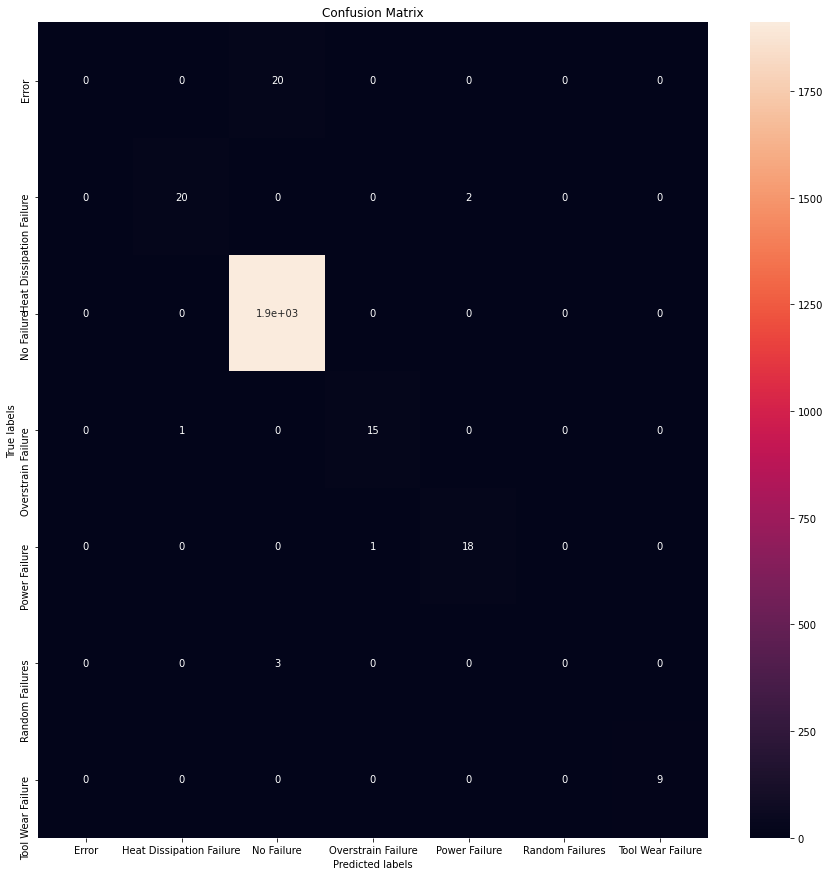

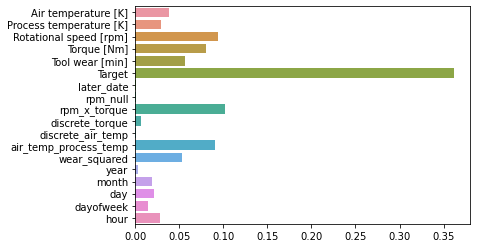

In [20]:
from sklearn.ensemble import RandomForestClassifier

y = df['Failure Type']
X_train, X_test, y_train, y_test = train_test_split(df_imp, y, test_size=0.2, stratify=y, random_state=10)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
eval(rf, X_test, y_test, X_train, y_train, y)


In [21]:
df_imp = df_imp.loc[~df['Failure Type'].isin(['Random Failures', 'Error'])]
df_imp = df_imp.drop(columns=['later_date', 'rpm_null', 'discrete_torque', 'discrete_air_temp'])
df = df.loc[~df['Failure Type'].isin(['Random Failures', 'Error'])]

No Failure                  2388.00
Heat Dissipation Failure      28.00
Power Failure                 23.75
Overstrain Failure            19.50
Tool Wear Failure             11.25
Name: Failure Type, dtype: float64
No Failure                  2388
Heat Dissipation Failure      28
Power Failure                 24
Overstrain Failure            20
Tool Wear Failure             11
Name: Failure Type, dtype: int64
                          precision    recall  f1-score   support

Heat Dissipation Failure       0.90      0.96      0.93        28
              No Failure       0.99      1.00      0.99      2388
      Overstrain Failure       0.73      0.40      0.52        20
           Power Failure       0.91      0.83      0.87        24
       Tool Wear Failure       0.00      0.00      0.00        11

                accuracy                           0.99      2471
               macro avg       0.71      0.64      0.66      2471
            weighted avg       0.98      0.99      0.98  

/home/adrian/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/adrian/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/adrian/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


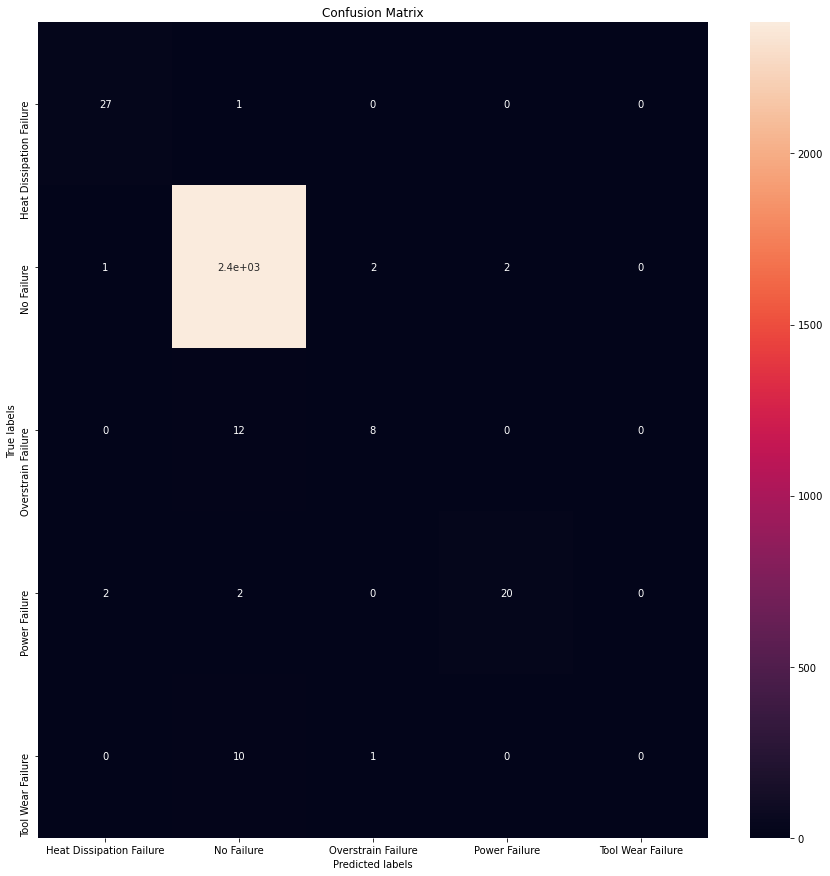

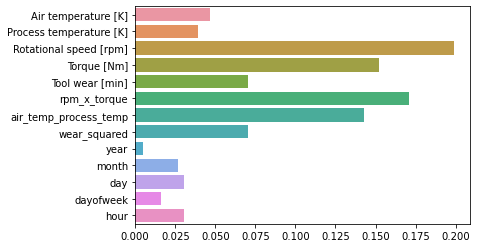

In [22]:
df_imp_drop_target = df_imp.drop(columns=['Target'])
y = df['Failure Type']
X_train, X_test, y_train, y_test = train_test_split(df_imp_drop_target, y, test_size=0.25, stratify=y, random_state=5)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
eval(rf, X_test, y_test, X_train, y_train, y)

No Failure                  2388.00
Heat Dissipation Failure      28.00
Power Failure                 23.75
Overstrain Failure            19.50
Tool Wear Failure             11.25
Name: Failure Type, dtype: float64
No Failure                  1911
Heat Dissipation Failure      22
Power Failure                 19
Overstrain Failure            16
Tool Wear Failure              9
Name: Failure Type, dtype: int64
                          precision    recall  f1-score   support

Heat Dissipation Failure       1.00      1.00      1.00        22
              No Failure       1.00      0.99      0.99      1911
      Overstrain Failure       0.56      0.88      0.68        16
           Power Failure       1.00      1.00      1.00        19
       Tool Wear Failure       0.29      0.22      0.25         9

                accuracy                           0.99      1977
               macro avg       0.77      0.82      0.79      1977
            weighted avg       0.99      0.99      0.99  

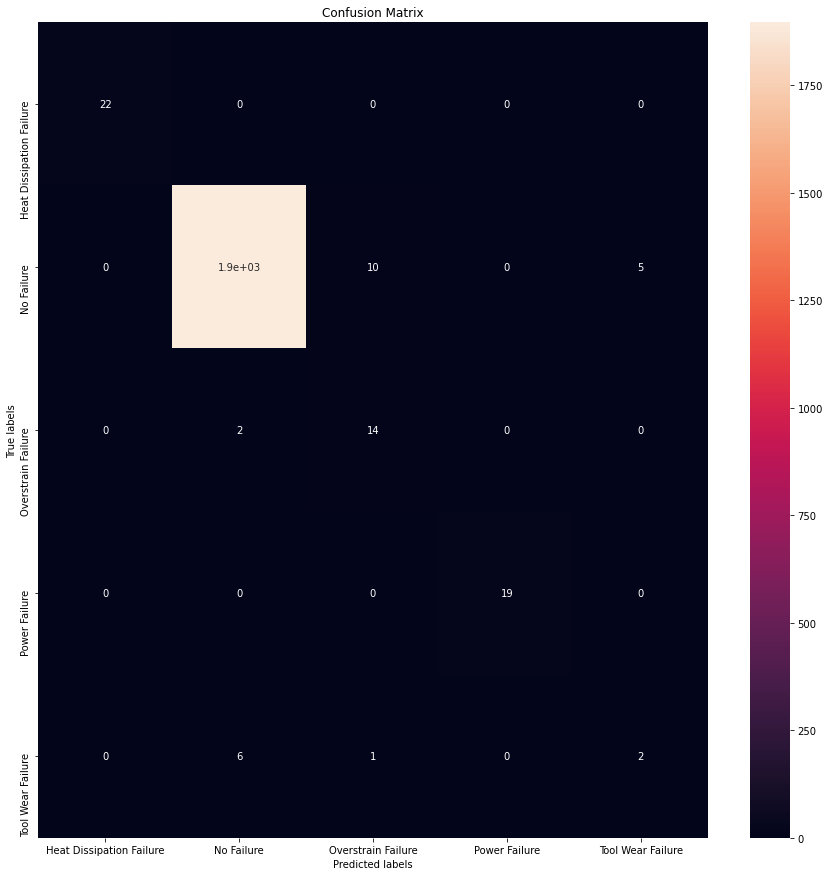

[[0.   1.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.  ]
 ...
 [0.2  0.15 0.11 0.54 0.  ]
 [0.   0.19 0.81 0.   0.  ]
 [0.   1.   0.   0.   0.  ]]


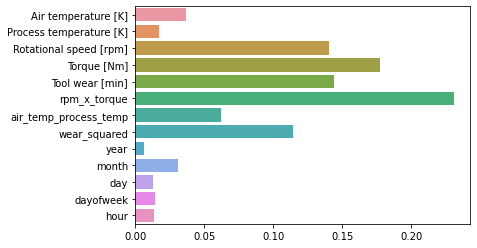

[1 1 1 ... 0 0 1]
[1.   1.   1.   ... 0.15 0.19 1.  ]


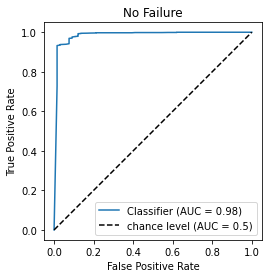

[0 0 0 ... 1 0 0]
[0.   0.   0.   ... 0.54 0.   0.  ]


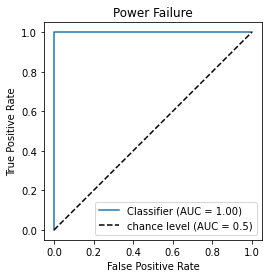

[0 0 0 ... 0 0 0]
[0. 0. 0. ... 0. 0. 0.]


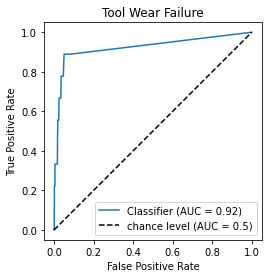

[0 0 0 ... 0 1 0]
[0.   0.   0.   ... 0.11 0.81 0.  ]


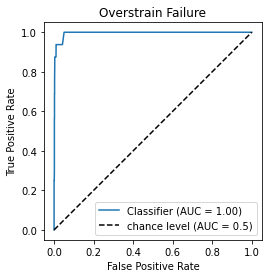

[0 0 0 ... 0 0 0]
[0.  0.  0.  ... 0.2 0.  0. ]


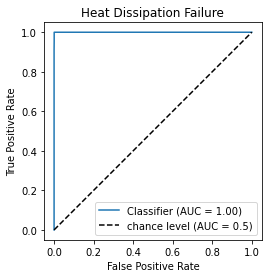

In [23]:
from imblearn.over_sampling import SVMSMOTE
from sklearn.ensemble import GradientBoostingClassifier
ros = SVMSMOTE()


X_train, X_test, y_train, y_test = train_test_split(df_imp_drop_target, y, test_size=0.2, stratify=y, random_state=5)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

rf = RandomForestClassifier(random_state=5)
rf.fit(X_resampled, y_resampled)
test, y_score = eval(rf, X_test, y_test, X_train, y_train, y, roc_curve=True)


In [24]:
y_score[y_test == 'Tool Wear Failure', :]

array([[0.  , 0.44, 0.  , 0.  , 0.56],
       [0.03, 0.73, 0.08, 0.  , 0.16],
       [0.02, 0.87, 0.  , 0.  , 0.11],
       [0.09, 0.85, 0.  , 0.  , 0.06],
       [0.  , 0.34, 0.  , 0.  , 0.66],
       [0.  , 1.  , 0.  , 0.  , 0.  ],
       [0.01, 0.64, 0.  , 0.  , 0.35],
       [0.02, 0.37, 0.52, 0.06, 0.03],
       [0.  , 0.85, 0.  , 0.  , 0.15]])

In [27]:
df['Failure Type'].value_counts()

No Failure                  9552
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Name: Failure Type, dtype: int64

In [31]:
df['UID'].unique().shape[0]

1.0

## Things to improve if more time

- cross validation
- segmented evaluation on date ranges and on types, may not be i.i.d
- fine tuning
- separate models
- remove "Random Failures"
- transformations on features (log, box cox)
- explainability per class e.g. SHAP values